In [1]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm # Progressbar (!)

2022-05-09 20:52:20.265576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 20:52:20.265596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

In [8]:
!ls "drive/MyDrive/data"

all  internet_archive_scifi_v3.txt  train  valid


In [6]:
# Where the text files are going to live.
# dataset_path = "drive/MyDrive/data"
dataset_path = "data/HitchhikersGuide"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

In [7]:
dataset_path

'data/HitchhikersGuide'

In [8]:
!ls $dataset_path
print("")
!ls $dataset_path_all
print("")
!ls $dataset_path_train
print("")
!ls $dataset_path_valid

all  raw  train  valid

HITCHHIKERS_GUIDE_core

HITCHHIKERS_GUIDE_core_train

HITCHHIKERS_GUIDE_core_valid


In [9]:
# Textfile preparation

dot_replace = " mydotreplacer"

def text_preparation(file_path):

  with open(file_path, mode="r") as file:
    data = file.read()
    data = data.replace(".", dot_replace)
  
  
  with open(file_path+"_dotrep.txt","w") as file:
    file.write(data)

text_preparation(dataset_path_all + "/HITCHHIKERS_GUIDE_core")
text_preparation(dataset_path_train + "/HITCHHIKERS_GUIDE_core_train")
text_preparation(dataset_path_valid + "/HITCHHIKERS_GUIDE_core_valid")

In [10]:
batch_size = 128
seed = 666

def create_dataset(dataset_path):
  dataset = preprocessing.text_dataset_from_directory(
      dataset_path,
      labels=None,
      batch_size=batch_size,
      seed=seed
      )
  return dataset

dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


2022-05-09 20:57:03.080879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 20:57:03.081230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 20:57:03.081291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-09 20:57:03.081331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-09 20:57:03.081372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [12]:
vocabulary_size = 20_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)

encoder.adapt(dataset_original_all)
vocabulary = encoder.get_vocabulary()
print(len(vocabulary), vocabulary[:300])

15676 ['', '[UNK]', 'mydotreplacer', 'the', 'and', 'of', 'to', 'a', 'it', 'he', 'was', 'in', 'that', 'said', 'you', 'i', 'his', 'had', 'on', 'at', 'with', 'this', 'they', 'for', 'arthur', 'is', 'what', 'as', 'ford', 'but', 'be', 'which', 'all', 'she', 'were', 'one', 'out', 'up', 'him', 'its', 'from', 'not', 'have', 'there', 'about', 'them', 'just', 'so', 'would', 'into', 'been', 'an', 'her', 'do', 'zaphod', 'if', 'no', 'very', 'by', 'or', 'we', 'like', 'are', 'again', 'then', 'me', 'know', 'now', 'down', 'time', 'could', 'some', 'well', 'their', 'see', 'back', 'through', 'who', 'over', 'way', 'when', 'something', 'dont', 'think', 'other', 'little', 'looked', 'where', 'going', 'your', 'get', 'thought', 'yes', 'more', 'can', 'off', 'only', 'didnt', 'because', 'did', 'moment', 'got', 'how', 'my', 'two', 'thing', 'good', 'man', 'any', 'ship', 'here', 'people', 'go', 'around', 'himself', 'say', 'seemed', 'im', 'away', 'things', 'suddenly', 'will', 'right', 'planet', 'look', 'small', 'much',

In [13]:
sequence_length = 64

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []
  
  padding_token_id = vocabulary.index("")
  assert padding_token_id == 0
  
  for samples in dataset: # samples = books
    for sample in tqdm(samples): # sample = book
      sample = encoder(sample).numpy()
      
      padding = [padding_token_id] * sequence_length
      padding = padding + list(sample)

      for start_index in range(0, len(sample) - sequence_length):
        x = sample[start_index:start_index + sequence_length]
        assert len(x) == sequence_length
        y = sample[start_index + sequence_length]

        x_inputs += [x]
        y_outputs += [y]

      #print(padding)
      #print(len(sample), sample)
      #assert False

  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

print("Done!")

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.40it/s]


Done!


In [14]:
from re import M
embedding_size = 64

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(256, return_sequences=True))
#model.add(layers.LSTM(1024, return_sequences=True))
model.add(layers.LSTM(256))
#model.add(layers.LSTM(24))
model.add(layers.Dropout(0.5))              # one way to handle overfitting
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 64)            1280000   
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           328704    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 20000)             5140000   
                                                                 
Total params: 7,274,016
Trainable params: 7,274,016
Non-

In [15]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(10_000).batch(512),
    epochs=10,
    validation_data=dataset_valid.cache().batch(512)
)

render_history(history)

Epoch 1/10
297/451 [==================>...........] - ETA: 4:04 - loss: 6.9268 - accuracy: 0.0716

KeyboardInterrupt: 

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 128)           1920000   
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 64, 1024)          4722688   
                                                                 
 lstm_1 (LSTM)               (None, 2048)              25174016  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 15000)             30735000  
                                                                 
Total params: 62,551,704
Trainable params: 62,551,704
No

In [29]:
import numpy as np

def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])
    
def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    text = text.replace(dot_replace, ".").replace("[UNK]", "42")
    #print(text)
    print("")
    return text

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  

# generate(model, "Arthur entered the bridge of", 100, temperature=1.0)

In [30]:
s = generate(model, "Arthur looked at ", 100, temperature=1.0)
s

'arthur looked at ford and an couple of one 42 42 again into went off. fie clambered from the back. she obviously arthur pushed it here that the small word would have hurled her since a spacecraft in front of which pocket then were alarmed. it was all one of the only end of which would old 42 and made a 42 stock. she sat out. the barman had shot it and lay going to himself into the other air to control that it exhibited plain. the new billion beasts simply tells they.'

In [31]:
s = generate(model, "Arthur looked at ", 300, temperature=.70)


In [32]:
s

'arthur looked at a 42 sun. it was just a 42. she could have been a 42 42 and 42 so it must be a 42. the whole guy was. he was very lost. this was some 42. she was going to discover she was going to a man and the 42 42. she hobbled back to the place. the barman passed. he had 42 by his own towel. it was looking at it to a 42 42 of upwards. he had remembered it. what did you to need to a large culture and you am why this is. she got his head on to his knees. she was sitting in the last place. she sighed. on the fact she had 42. he had 42 the last 42 42. there was something to make his job with this pocket. she didnt want to go to the distant box. a few voice. lay at the 42 bright 42 slowly at the sun. it was a bit at the 42. she was 42 and equipment. he was asleep. she had a lot of a monster. he felt and it was some numbers of her sort of 42. the 42 were sitting forward in the sky and he started to 42 with the bar of a large 42 42 she had been born on the air. he were a good 42. she had

In [33]:
generate(model, "This friend of his had first arrived on the planet some fifteen Earth years previously and he had worked hard to", 300, temperature=.70)

'this friend of his had first arrived on the planet some fifteen earth years previously and he had worked hard to calm and put it to him. the barman of the frozen heart of the singer was on the 42 and make the stage 42 was 42. the barman was 42 which was the one of the 42 42 which had been any taken 42 and had 42 42 in a 42 42. that had been 42 in the notice that he was doing to the 42 of the 42. she knew if it was 42. it was going to be the most few spaceship a lot of your 42 and 42 with a thin 42. this is a 42. the 42 was a little 42 42 movie. she had to go with and relaxed 42 but she was looking in the towel on the heat. it was 42 up and fell 42 and started to feel up. there was the big one of the ship. they were fairly good and a 42 for a home of some shapes. they had been and a 42. the next guide to this other 42. arthur seemed to go out of the universe. and so what. what are you sure... yeah said ford. i was just doing a sort of life on it. i dont know what...... i am the 42. its

In [ ]:
generate(model, "Arthur and Ford ", 300, temperature=.2)

In [47]:
from re import M
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.LSTM(1024, return_sequences=True))
model.add(layers.LSTM(256))
#model.add(layers.LSTM(24))
model.add(layers.Dropout(0.5))              # one way to handle overfitting
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 64, 128)           2560000   
                                                                 
 dropout_8 (Dropout)         (None, 64, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64, 512)           1312768   
                                                                 
 lstm_10 (LSTM)              (None, 64, 1024)          6295552   
                                                                 
 lstm_11 (LSTM)              (None, 256)               1311744   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 20000)            

Epoch 1/10
451/451 [==============================] - 255s 558ms/step - loss: 6.6379 - accuracy: 0.0690 - val_loss: 6.9243 - val_accuracy: 0.0702
Epoch 2/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5331 - accuracy: 0.0695 - val_loss: 6.9685 - val_accuracy: 0.0702
Epoch 3/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5534 - accuracy: 0.0702 - val_loss: 6.9938 - val_accuracy: 0.0702
Epoch 4/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5685 - accuracy: 0.0697 - val_loss: 7.0198 - val_accuracy: 0.0702
Epoch 5/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5802 - accuracy: 0.0699 - val_loss: 7.0561 - val_accuracy: 0.0702
Epoch 6/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5903 - accuracy: 0.0698 - val_loss: 7.0722 - val_accuracy: 0.0702
Epoch 7/10
451/451 [==============================] - 249s 553ms/step - loss: 6.5814 - accuracy: 0.0701 - val_loss: 7.0352 -

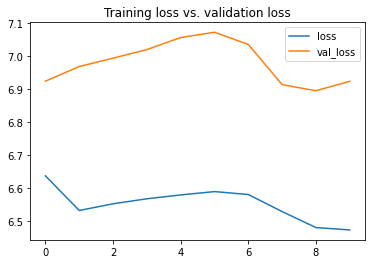

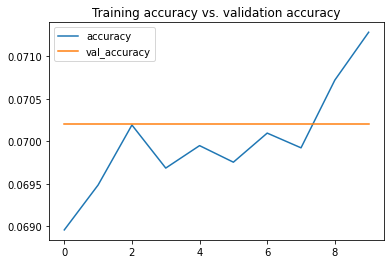

In [48]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(10_000).batch(512),
    epochs=10,
    validation_data=dataset_valid.cache().batch(512)
)

render_history(history)

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 64, 128)           2560000   
                                                                 
 dropout_8 (Dropout)         (None, 64, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64, 512)           1312768   
                                                                 
 lstm_10 (LSTM)              (None, 64, 1024)          6295552   
                                                                 
 lstm_11 (LSTM)              (None, 256)               1311744   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 20000)            

In [50]:
generate(model, "This friend of his had first arrived on the planet some fifteen Earth years previously and he had worked hard to", 300, temperature=.70)

'this friend of his had first arrived on the planet some fifteen earth years previously and he had worked hard to. was the very the. 42 was. and it ford that. quite to to the the meanwhile the. 42 with i and the the the and into an to them and was 42 was beast your to into who the. she was never an that the and one now what. been nuts for they... 42 didnt to to that and.. like the was it 42. 42 of of face a for. 42 so he it 42 him he. said was from this 42. and and. me was thats said. 42 the a 42 had the the desk to said his. back the she to i. to. peered and or. it slowly sorts said they up. a the shot it it in from why he. four the and well.. a... 42 his i for he 42 what of you said 42 as. it ive to 42 what than she in man just. the was the as and 42 42 was of her you. of in. was with 42.. yes someone a.. 42 and. or make of were. 42 it the this the. there she the he. know the she was 42. and. was is. its of of said the. she he.. it said 42. and. it. what a.. one. it looked what a the

In [51]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
#model.add(layers.Dropout(0.3))
model.add(layers.LSTM(512, return_sequences=True))
#model.add(layers.LSTM(1024, return_sequences=True))
#model.add(layers.LSTM(256))
model.add(layers.LSTM(24))
model.add(layers.Dropout(0.5))              # one way to handle overfitting
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 64, 128)           2560000   
                                                                 
 lstm_12 (LSTM)              (None, 64, 512)           1312768   
                                                                 
 lstm_13 (LSTM)              (None, 24)                51552     
                                                                 
 dropout_10 (Dropout)        (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 20000)             500000    
                                                                 
Total params: 4,424,320
Trainable params: 4,424,320
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
451/451 [==============================] - 54s 114ms/step - loss: 7.1012 - accuracy: 0.0591 - val_loss: 6.6630 - val_accuracy: 0.0702
Epoch 2/10
451/451 [==============================] - 50s 111ms/step - loss: 6.4999 - accuracy: 0.0721 - val_loss: 6.7083 - val_accuracy: 0.0702
Epoch 3/10
451/451 [==============================] - 50s 112ms/step - loss: 6.4918 - accuracy: 0.0720 - val_loss: 6.7391 - val_accuracy: 0.0702
Epoch 4/10
451/451 [==============================] - 51s 112ms/step - loss: 6.4883 - accuracy: 0.0721 - val_loss: 6.6376 - val_accuracy: 0.0702
Epoch 5/10
451/451 [==============================] - 50s 112ms/step - loss: 6.3737 - accuracy: 0.0743 - val_loss: 6.5915 - val_accuracy: 0.0699
Epoch 6/10
451/451 [==============================] - 51s 112ms/step - loss: 6.2999 - accuracy: 0.0765 - val_loss: 6.6007 - val_accuracy: 0.0665
Epoch 7/10
451/451 [==============================] - 51s 112ms/step - loss: 6.2566 - accuracy: 0.0771 - val_loss: 6.5924 - val_ac

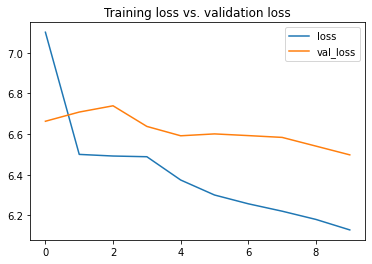

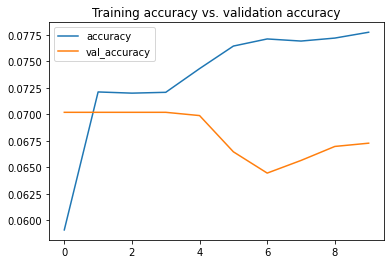

In [52]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(10_000).batch(512),
    epochs=10,
    validation_data=dataset_valid.cache().batch(512)
)

render_history(history)